In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms as T
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image
from torch import optim
from IPython.display import clear_output

In [2]:
transforms = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

target_transforms = T.Compose([
    T.Resize((256, 256)),
    T.PILToTensor(),
    T.Lambda(lambda x: (x-1).long())
])

In [3]:
train_dataset = OxfordIIITPet('/kaggle/working', transform=transforms, 
                              target_transform=target_transforms, download=True,
                              target_types='segmentation')
valid_dataset = OxfordIIITPet('/kaggle/working', split='test', transform=transforms,
                             target_transform=target_transforms, download=True,
                             target_types='segmentation')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [4]:
def conv_plus_conv(in_channels: int, out_channels: int):
    """
    Makes UNet block
    :param in_channels: input channels
    :param out_channels: output channels
    :return: UNet block
    """
    
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3,
                 padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3,
                 padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU()
    )


class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        base_channels = 32
        
        self.down1 = conv_plus_conv(3, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels*2)
        self.down3 = conv_plus_conv(base_channels*2, base_channels*4)
        self.down4 = conv_plus_conv(base_channels*4, base_channels*8)
        
        self.up1 = conv_plus_conv(base_channels*2, base_channels)
        self.up2 = conv_plus_conv(base_channels*4, base_channels)
        self.up3 = conv_plus_conv(base_channels*8, base_channels*2)
        self.up4 = conv_plus_conv(base_channels*16, base_channels*4)
        
        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)
        
        self.bottleneck = conv_plus_conv(base_channels*8, base_channels*8)
        
        self.downsample = nn.MaxPool2d(2)
        
        
    def forward(self, x):
        # 3 * N * N
        
        residual1 = self.down1(x) # base_channels * N * N
        output = self.downsample(residual1) # base_channels * N//2 * N//2
        
        residual2 = self.down2(output) # base_channels*2 * N//2 * N//2
        output = self.downsample(residual2) # base_channels*2 * N//4 * N//4
        
        residual3 = self.down3(output) # base_channels*4 * N//4 * N//4
        output = self.downsample(residual3) # base_channels*4 * N//8 * N//8
        
        residual4 = self.down4(output) # base_channels*8 * N//8 * N//8
        output = self.downsample(residual4) # base_channels*8 * N//16 * N//16
        
        output = self.bottleneck(output) # base_channels*8 * N//16 * N//16
        
        output = nn.functional.interpolate(output, scale_factor=2) # base_channels*8 * N//8 * N//8
        output = torch.cat((output, residual4), dim=1) # base_channels*16 * N//8 * N//8
        output = self.up4(output) # base_channels*4 * N//8 * N//8
        
        output = nn.functional.interpolate(output, scale_factor=2) # base_channels*4 * N//4 * N//4
        output = torch.cat((output, residual3), dim=1) # base_channels*8 * N//4 * N//4
        output = self.up3(output) # base_channels*2 * N//4 * N//4
        
        output = nn.functional.interpolate(output, scale_factor=2) # base_channels*2 * N//2 * N//2
        output = torch.cat((output, residual2), dim=1) # base_channels*4 * N//2 * N//2
        output = self.up2(output) # base_channels * N//2 * N//2
        
        output = nn.functional.interpolate(output, scale_factor=2) # base_channels * N * N
        output = torch.cat((output, residual1), dim=1) # base_channels*2 * N * N
        output = self.up1(output) # base_channels * N * N
        
        output = self.out(output) # 3 * N * N
        
        return output

In [5]:
def train(model : nn.Module) -> tuple[float, float]:
    model.train()
    
    train_loss = []
    total = 0
    correct = 0
    
    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)
        
        x, y = x.to(device), y.squeeze(1).to(device)
        
        optimizer.zero_grad()
        
        output = model(x)
        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))
        train_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y==y_pred).sum().item()
        
    return np.mean(train_loss), correct/total    

In [6]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader) -> tuple[float, float]:
    model.eval()
    
    valid_loss = []
    total = 0
    correct = 0
    
    for x, y in tqdm(loader, desc='Evaluate'):
        bs = y.size(0)
        
        x, y = x.to(device), y.squeeze(1).to(device)
        
        output = model(x)
        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))
        valid_loss.append(loss.item())
        
        _, y_pred = output.max(dim=1)
        total += y.size(0)* y.size(1) * y.size(2)
        correct += (y==y_pred).sum().item()
        
    return np.mean(valid_loss), correct/total    

In [7]:
def plot_stats(train_loss: list[float], valid_loss: list[float],
              train_acc : list[float], valid_acc: list[float], title: str):
    plt.figure(figsize=(16, 8))
    plt.plot(train_loss, label='Train')
    plt.plot(valid_loss, label='Valid')
    plt.legend()
    plt.grid()
    plt.title(title + ' loss')
    plt.show()
    
    plt.figure(figsize=(16, 8))
    plt.plot(train_acc, label='Train')
    plt.plot(valid_acc, label='Valid')
    plt.legend()
    plt.grid()
    plt.title(title + ' accuracy')
    plt.show()

In [8]:
@torch.inference_mode()
def visualize(model, batch):
    model.eval()
    
    xs, ys = batch
    
    to_pil = T.ToPILImage()
    
    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x.unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')

        ax[0].imshow(to_pil(x))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 3:
            break

In [9]:
#!g1.1
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        
        if epoch==(num_epochs-1):
            print(valid_accuracy_history[-1])

        visualize(model, next(iter(valid_loader)))

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [11]:
model = Unet().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

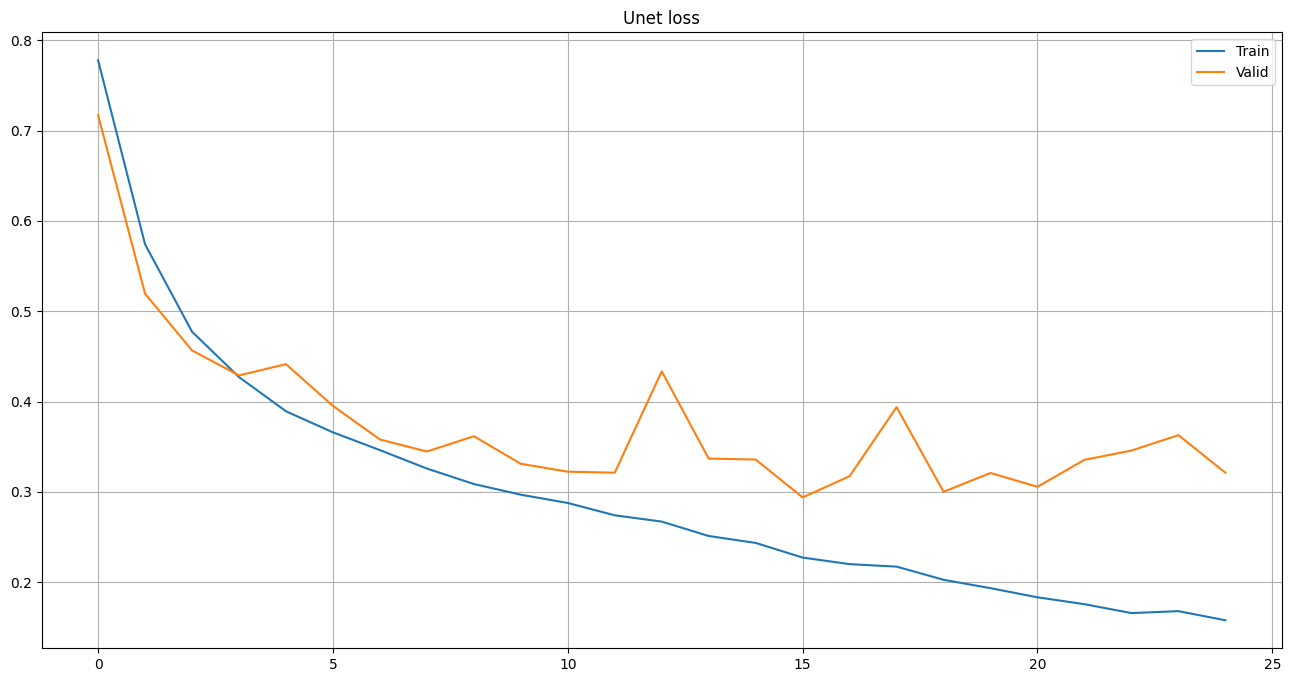

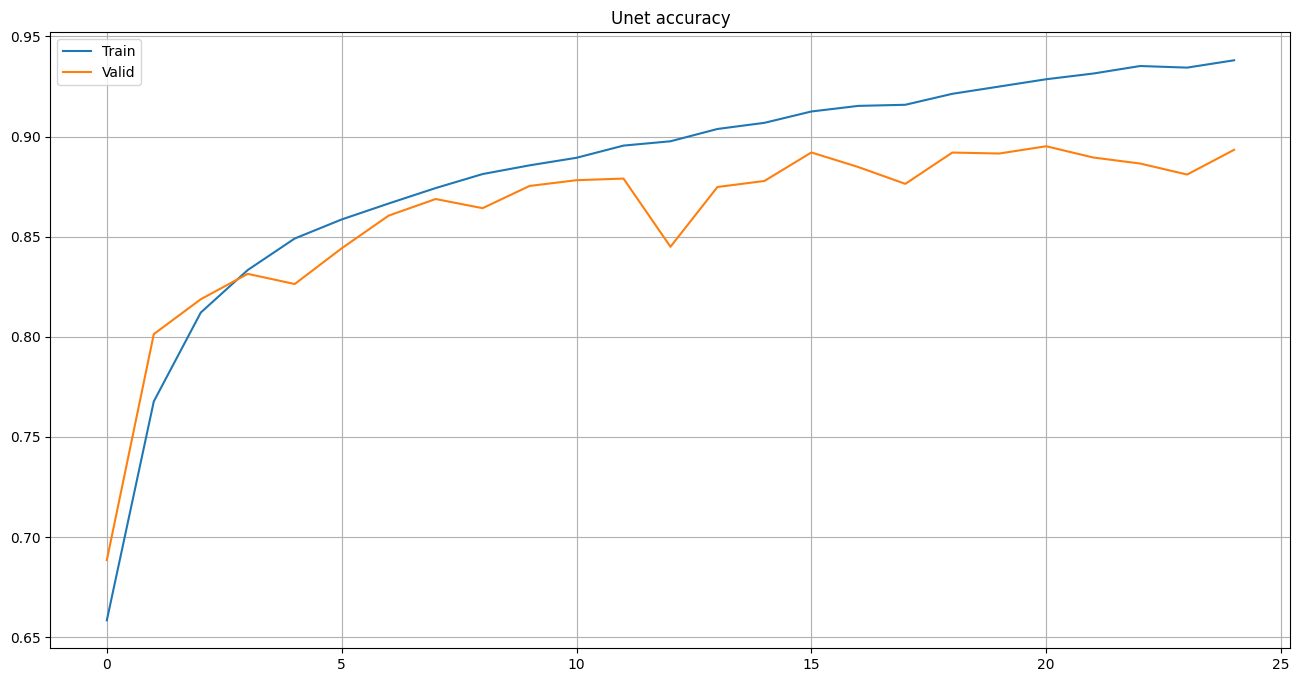

0.893384728128886


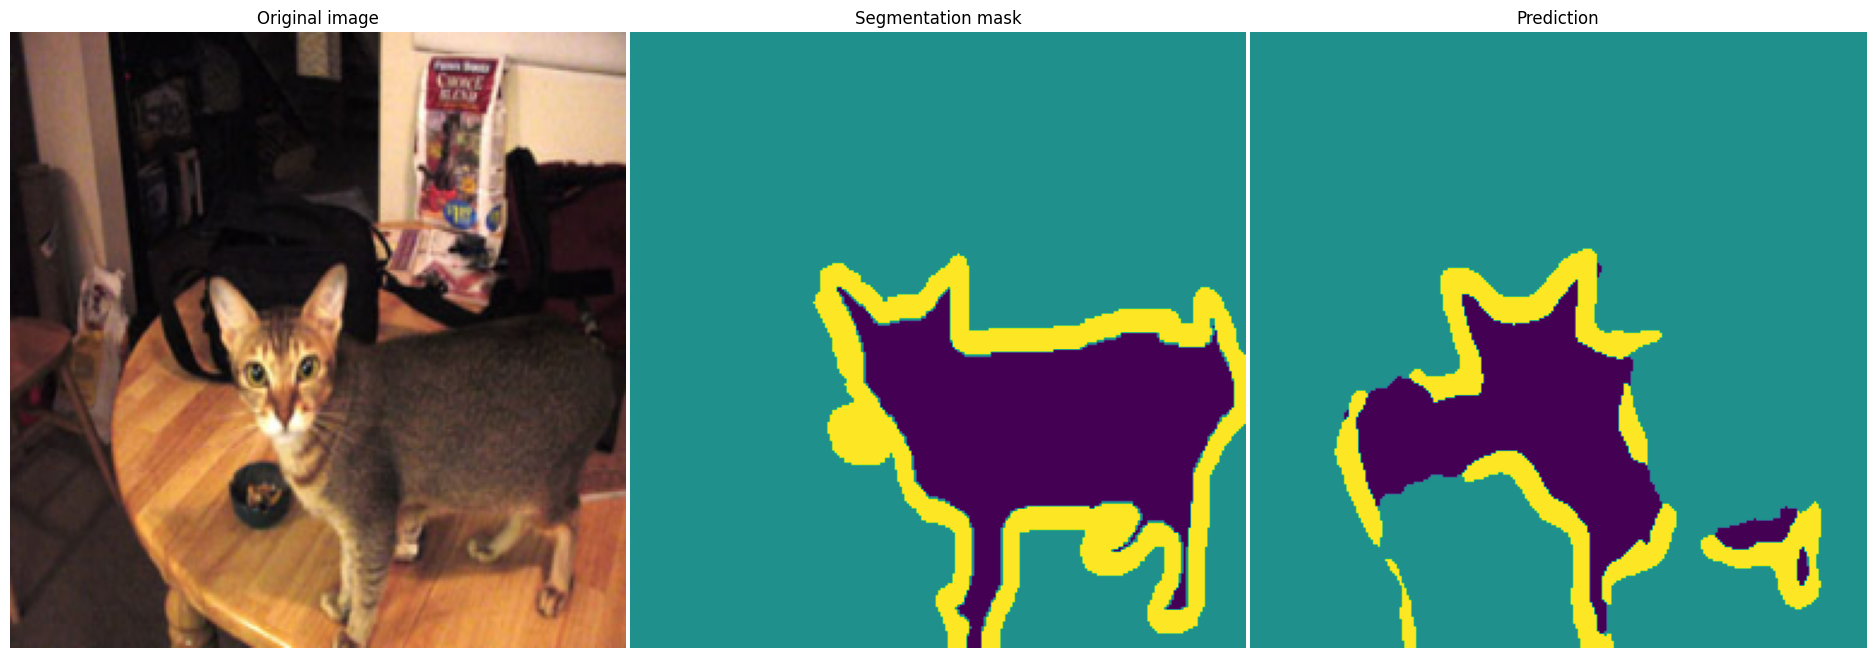

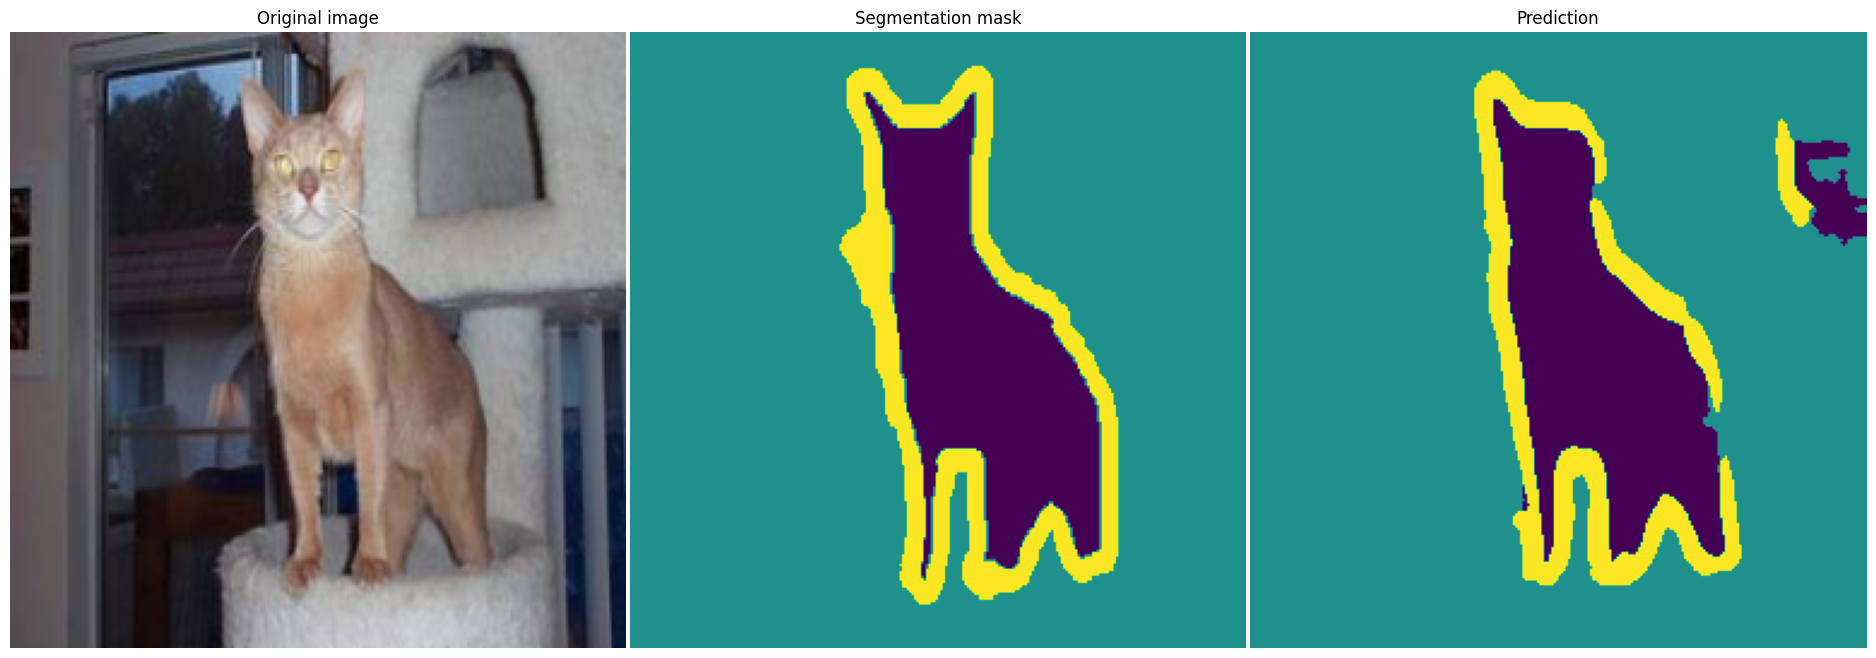

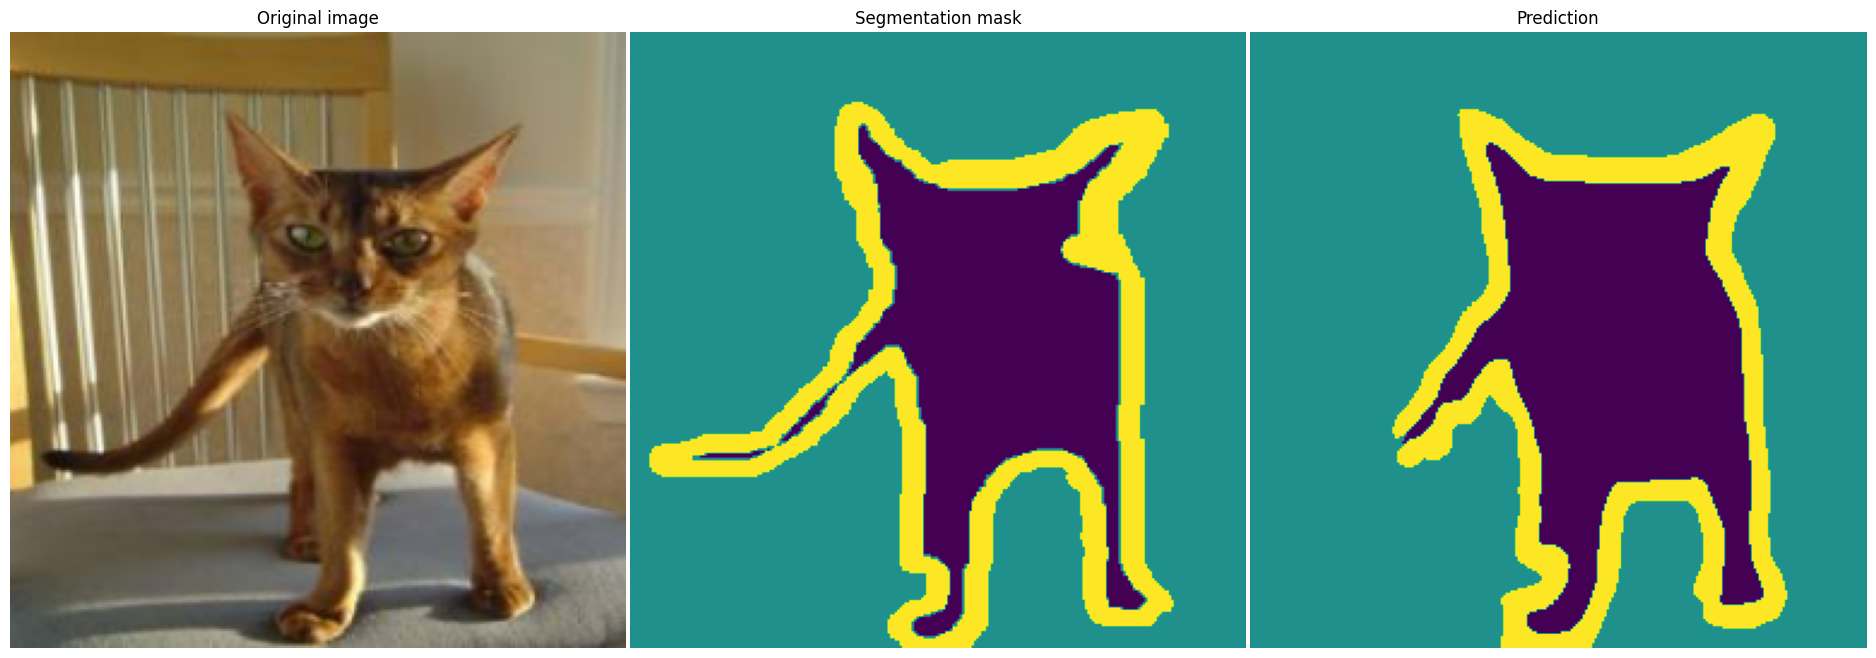

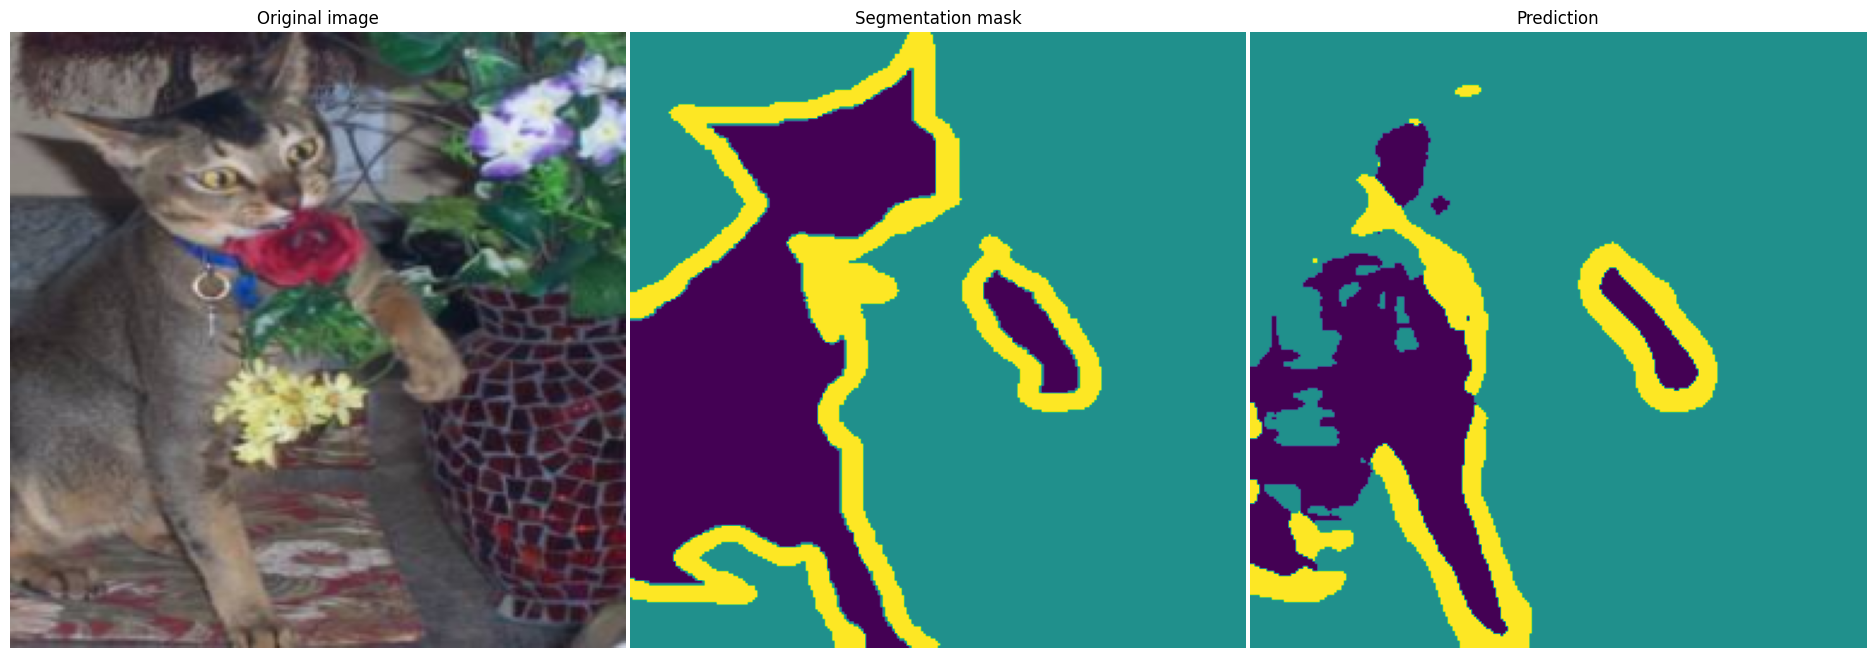

In [12]:
whole_train_valid_cycle(model, 25, 'Unet')

In [19]:
from torch.utils.data import Subset

np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200)

subset_valid = Subset(valid_dataset, idx)

predictions = []

with torch.no_grad():
    for image in subset_valid:
        image = image[0].unsqueeze(0).to(device)
        output = model(image)
        output = output.max(dim=1)
        output = output.values.to(torch.uint8)
        output = output.unsqueeze(1)
        predictions.append(output.cpu())
        
predictions_uint8 = torch.cat(predictions, dim=0)

print(predictions_uint8.shape)

torch.Size([200, 1, 256, 256])


In [21]:
torch.save(predictions_uint8, 'predictions.pt')